# Collection of GFS Forecast Maps from Thredds Server via NCSS and Siphon

## Justin Richling
## 11/15/18

https://doi.org/10.6084/m9.figshare.5244637.v1

In [ ]:
# Random Library Imports
import subprocess,os,glob,tempfile,re,webbrowser,io,sys,types,\
time

# Importing Datetime Libraries
from datetime import datetime, timedelta

# CartoPy Map Plotting Libraires
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import Proj 

# Numerical and Scientific Libraries
import numpy as np
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter

# Accessing Data from External Databases via XLM Catalog
from siphon.ncss import NCSS
from siphon.catalog import TDSCatalog

# MetPy Libraries
import metpy
import metpy.calc as mpcalc
from metpy.units import masked_array, units
from metpy.plots import ctables
from metpy.plots import add_metpy_logo
from metpy.constants import g

# NetCDF Libraries
from netCDF4 import Dataset
from netCDF4 import num2date

# More Image Manipulation Options
from PIL import Image as PILImage
from IPython.display import Image

# Ipyhton Options
from IPython import get_ipython
from nbformat import current
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import HTML, display, Image

# Matplotlib Plotting Libraries
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm, Normalize
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from matplotlib.colors import LinearSegmentedColormap

# Warnings
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Set the font 
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 18,
        }

## Helper Functions

In [4]:
# Thanks to the crew over at Metpy for this handy little function
def find_time_var(var, time_basename='time'):
    for coord_name in var.coordinates.split():
        if coord_name.startswith(time_basename):
            return coord_name
    raise ValueError('No time variable found for ' + var.name)

<h2>----------------------------------------------//---------------------------------------------------------</h2>

## Set the Map Projection

In [5]:
# Set Projection of Data
datacrs = ccrs.PlateCarree()

# Set Projection of Plot
plotcrs = ccrs.LambertConformal(central_latitude=[30, 60], central_longitude=-100)

# Add Map Features
states_provinces = cfeature.NaturalEarthFeature(category='cultural',
    name='admin_1_states_provinces_lakes',scale='50m', facecolor='none')

country_borders = cfeature.NaturalEarthFeature(category='cultural',
    name='admin_0_countries',scale='50m', facecolor='none')

# Colorbar Axis Placement (under figure)
colorbar_axis = [0.183, 0.09, 0.659, 0.03] # [left, bottom, width, height]

# Lat/Lon Extents [lon0,lon1,lat0,lat1]
extent = [-130., -70, 20., 60.]

<h2>----------------------------------------------//---------------------------------------------------------</h2>

## Set a list for the 24 hour forecast time steps

In [6]:
now = datetime.utcnow()
#now = datetime(2019,2,7,18,0)
today_day = int('{0:%d}'.format(now))
today_year = int('{0:%Y}'.format(now))
today_month = int('{0:%m}'.format(now))
print(today_day,today_year,today_month)

forecast_times = []
forecast_times.append(now)
#for i in range(4,8):
#    forecast_times.append(datetime(today_year,today_month,today_day,i*3,0))
#for i in range(0,5):
#    forecast_times.append(datetime(today_year,today_month,today_day+1,i*3,0))
forecast_times

11 2019 3


[datetime.datetime(2019, 3, 11, 22, 14, 30, 130585)]

<h2>----------------------------------------------//---------------------------------------------------------</h2>

## Figure out where the saved maps will go

In [ ]:
# Set a path to save the plots with string format for the date to set the month and day 
im_save_path ="/path/to/saved/images/"
print(im_save_path)

# Check to see if the folder already exists, if not create it
if not os.path.isdir(im_save_path):
    os.makedirs(im_save_path)

# Uncomment if you want to automatically change to the map folder    
#os.chdir(im_save_path)

<h2>----------------------------------------------//---------------------------------------------------------</h2>

## Start at the top of the thredds catalog

In [8]:
from siphon.catalog import TDSCatalog
top_cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog.xml')
ref = top_cat.catalog_refs['Forecast Model Data']
new_cat = ref.follow()
model = new_cat.catalog_refs[4]
gfs_cat = model.follow()
ds = gfs_cat.datasets[1]
print("Variable Name:",ds.name)
print("Path:",ds.url_path)

Variable Name: Best GFS Quarter Degree Forecast Time Series
Path: grib/NCEP/GFS/Global_0p25deg/Best


<h2>----------------------------------------------//---------------------------------------------------------</h2>
<h2>----------------------------------------------//---------------------------------------------------------</h2>

<h1><font style="font-size:32px"><center>-- Plotting all of the GFS forecast hours for the current day --</center></font></h1>

<h2><font><center>-- 1000 and 500mb Heights --</center></font></h2>

2019_03_11_21Z


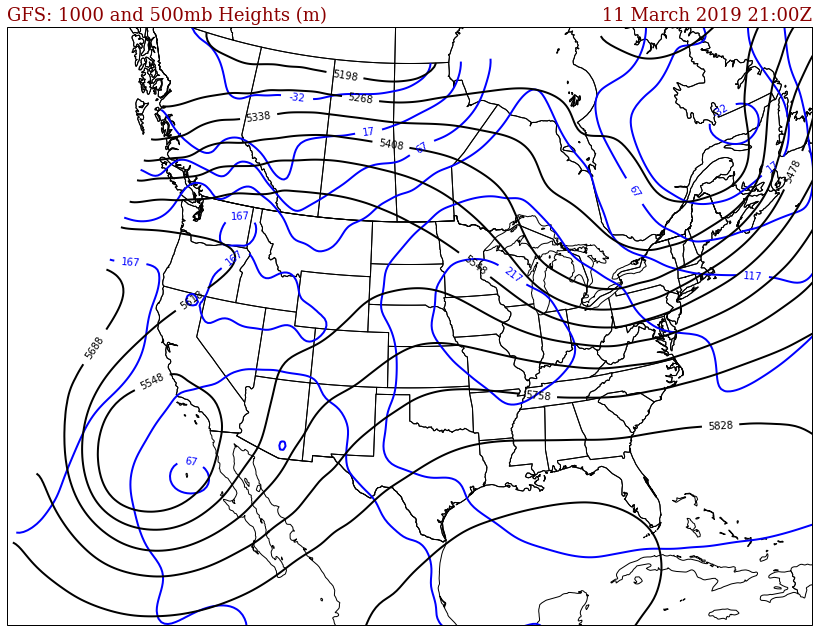

done.


In [11]:
for i in forecast_times:
    ds = gfs_cat.datasets[1]
    subset = ds.subset()
    query_data = subset.query()
    query_data.lonlat_box(west=-130, east=-50, south=10, north=60)

# Allow for NetCDF files
    query_data.accept('netcdf4')
    query_data.time(i)
    data = query_data.variables('Geopotential_height_isobaric')

# Finally attempt to access the data
    data = subset.get_data(query_data)
    lat = data.variables['lat'][:].squeeze()
    lon = data.variables['lon'][:].squeeze()
    lev_500 = np.where(data.variables['isobaric'][:] == 50000)[0][0]
    hght_500 = data.variables['Geopotential_height_isobaric'][0, lev_500, :, :]
    
    # Create a figure object, title it, and do the plots.
    fig = plt.figure(figsize = (17.,11.))

    add_metpy_logo(fig, 30, 940, size='small')

# Add the map and set the extent
    ax5 = plt.subplot(1,1,1, projection=plotcrs)
    ax5.set_extent(extent, datacrs)

# Add state boundaries to plot
    ax5.add_feature(states_provinces, edgecolor='k', linewidth=1)

# Add country borders to plot
    ax5.add_feature(country_borders, edgecolor='black', linewidth=1)

# Convert number of hours since the reference time into an actual date
    time_var = data.variables[find_time_var(data.variables['Geopotential_height_isobaric'])]
    time_final = num2date(time_var[:].squeeze(), time_var.units)
    print(str(time_final)[:4]+"_"+str(time_final)[5:7]+"_"+str(time_final)[8:10]+"_"+str(time_final)[11:13]+"Z")
    file_time = str(time_final)[:4]+"_"+str(time_final)[5:7]+"_"+str(time_final)[8:10]+"_"+str(time_final)[11:13]+"Z"
    
# Plot Title
    plt.title('GFS: 1000 and 500mb Heights (m)',loc='left',fontdict=font)
    plt.title(' {0:%d %B %Y %H:%MZ}'.format(time_final),loc='right',fontdict=font)

                                        # Heights - 1000mb
#---------------------------------------------------------------------------------------------------
    lev_1000 = np.where(data.variables['isobaric'][:] == 100000)[0][0]

    hght_1000 = data.variables['Geopotential_height_isobaric'][0, lev_1000, :, :]
    MIN = hght_1000.min()
    MAX = hght_1000.max()
#print hght_1000.min(),hght_1000.max()
    hght_1000 = ndimage.gaussian_filter(hght_1000, sigma=3, order=0) * units.meter

    clev1000 = np.arange(MIN, MAX, 50)
    cs = ax5.contour(lon, lat, hght_1000.m, clev1000, colors='blue', linewidths=2.0,
                linestyles='solid', transform=ccrs.PlateCarree())
    plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

                                        # Heights - 500mb
#---------------------------------------------------------------------------------------------------
    MIN = hght_500.min()
    MAX = hght_500.max()
    #print hght_500.min(),hght_500.max()
    hght_500 = ndimage.gaussian_filter(hght_500, sigma=3, order=0) * units.meter

    clev500 = np.arange(MIN, MAX, 70)
    cs = ax5.contour(lon, lat, hght_500.m, clev500, colors='black', linewidths=2.0,
                linestyles='solid', transform=ccrs.PlateCarree())
    plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

    plt.show()
#---------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------

    
    GFS_1000_500 = im_save_path+"GFS/1000_500mb/"
    if not os.path.isdir(GFS_1000_500):
        os.makedirs(GFS_1000_500)
    fig.savefig(GFS_1000_500+"1000_500mb_Heights_"+file_time+".png",
            bbox_inches='tight',dpi=120)
    plt.close(fig)
print('done.')